In [1]:
# Equity Curve Analysis for Mean Reversion Strategy
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load and prepare the data
file_path = 'equity_curves/OrderFlowImbalanceStrategy_20251010_102057.csv'
df = pd.read_csv(file_path)

# Convert exit_date to datetime
df['exit_date'] = pd.to_datetime(df['exit_date'])

# Extract additional features
df['date'] = df['exit_date'].dt.date
df['hour'] = df['exit_date'].dt.hour
df['day_of_week'] = df['exit_date'].dt.day_name()

# Extract trade type categories (group by base type, ignore percentages)
def extract_trade_category(trade_type):
    if 'TAKE_PROFIT' in trade_type:
        return 'TAKE_PROFIT'
    elif 'STOP_LOSS' in trade_type:
        return 'STOP_LOSS'
    elif 'MEAN_REVERSION_Z' in trade_type:
        return 'MEAN_REVERSION_Z'
    elif 'LIQUIDATION' in trade_type:
        return 'LIQUIDATION'
    else:
        return trade_type

df['trade_category'] = df['trade_type'].apply(extract_trade_category)

print(f"Data loaded successfully!")
print(f"Total trades: {len(df)}")
print(f"Date range: {df['exit_date'].min()} to {df['exit_date'].max()}")
print(f"Final PnL: {df['cumulative_pnl'].iloc[-1]:.4f}")
print(f"\nTrade categories distribution (grouped):")
print(df['trade_category'].value_counts())


Data loaded successfully!
Total trades: 331
Date range: 2025-09-08 04:20:54+00:00 to 2025-09-12 22:04:24+00:00
Final PnL: 1.1043

Trade categories distribution (grouped):
trade_category
STOP_LOSS               147
TAKE_PROFIT              96
OFI_SLOPE_SELL_BURST     81
LIQUIDATION               7
Name: count, dtype: int64


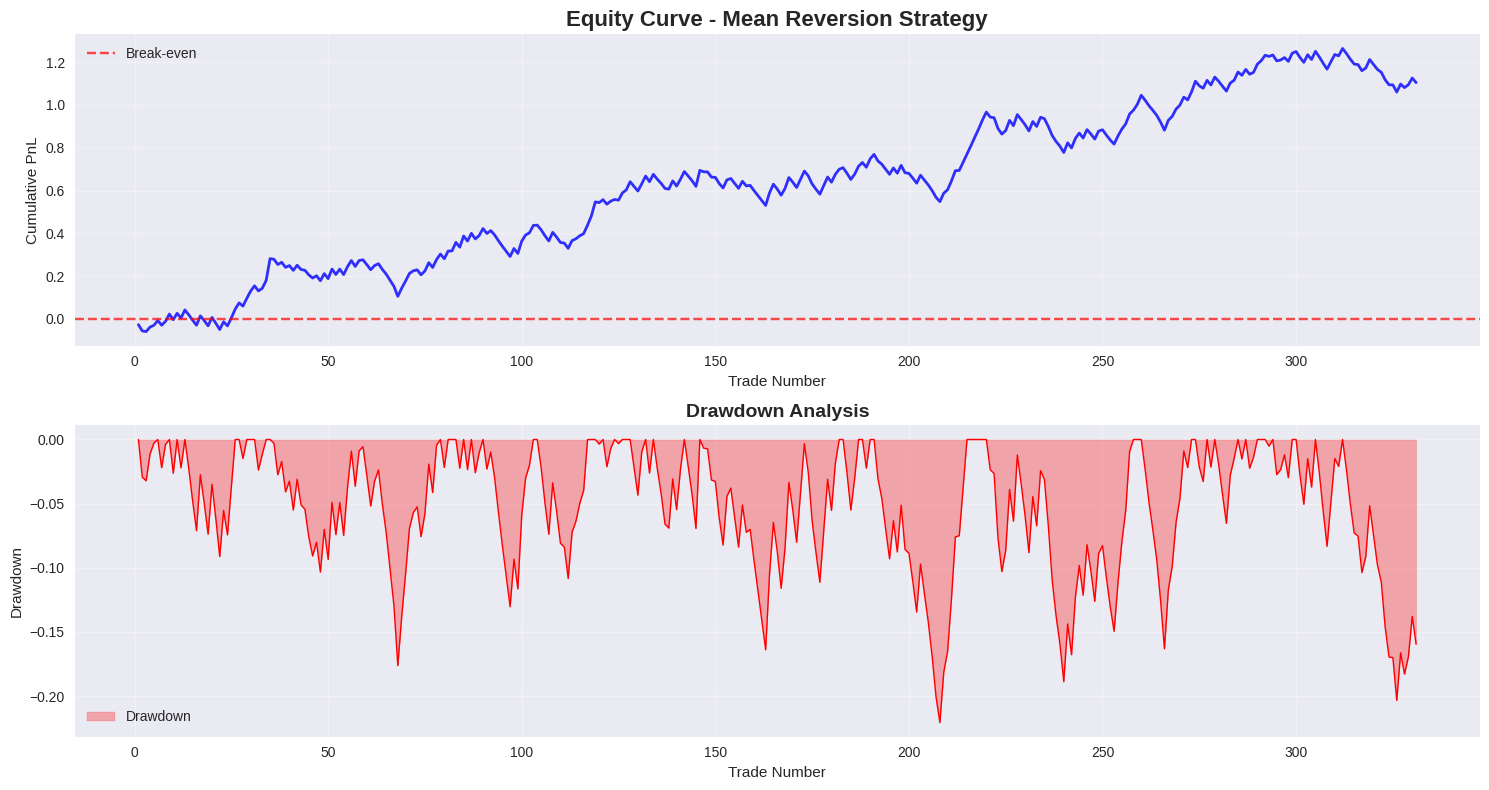

Final PnL: 1.1043
Maximum Drawdown: -0.2207
Total Trades: 331


In [3]:
# 1. EQUITY CURVE PLOT
plt.figure(figsize=(15, 8))

# Main equity curve
plt.subplot(2, 1, 1)
plt.plot(df['trade_number'], df['cumulative_pnl'], linewidth=2, color='blue', alpha=0.8)
plt.title('Equity Curve - Mean Reversion Strategy', fontsize=16, fontweight='bold')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative PnL')
plt.grid(True, alpha=0.3)

# Add horizontal line at zero
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Break-even')
plt.legend()

# Drawdown plot
plt.subplot(2, 1, 2)
# Calculate running maximum and drawdown
running_max = df['cumulative_pnl'].expanding().max()
drawdown = df['cumulative_pnl'] - running_max
plt.fill_between(df['trade_number'], drawdown, 0, color='red', alpha=0.3, label='Drawdown')
plt.plot(df['trade_number'], drawdown, color='red', linewidth=1)
plt.title('Drawdown Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Trade Number')
plt.ylabel('Drawdown')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Print key metrics
max_drawdown = drawdown.min()
final_pnl = df['cumulative_pnl'].iloc[-1]
print(f"Final PnL: {final_pnl:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")
print(f"Total Trades: {len(df)}")


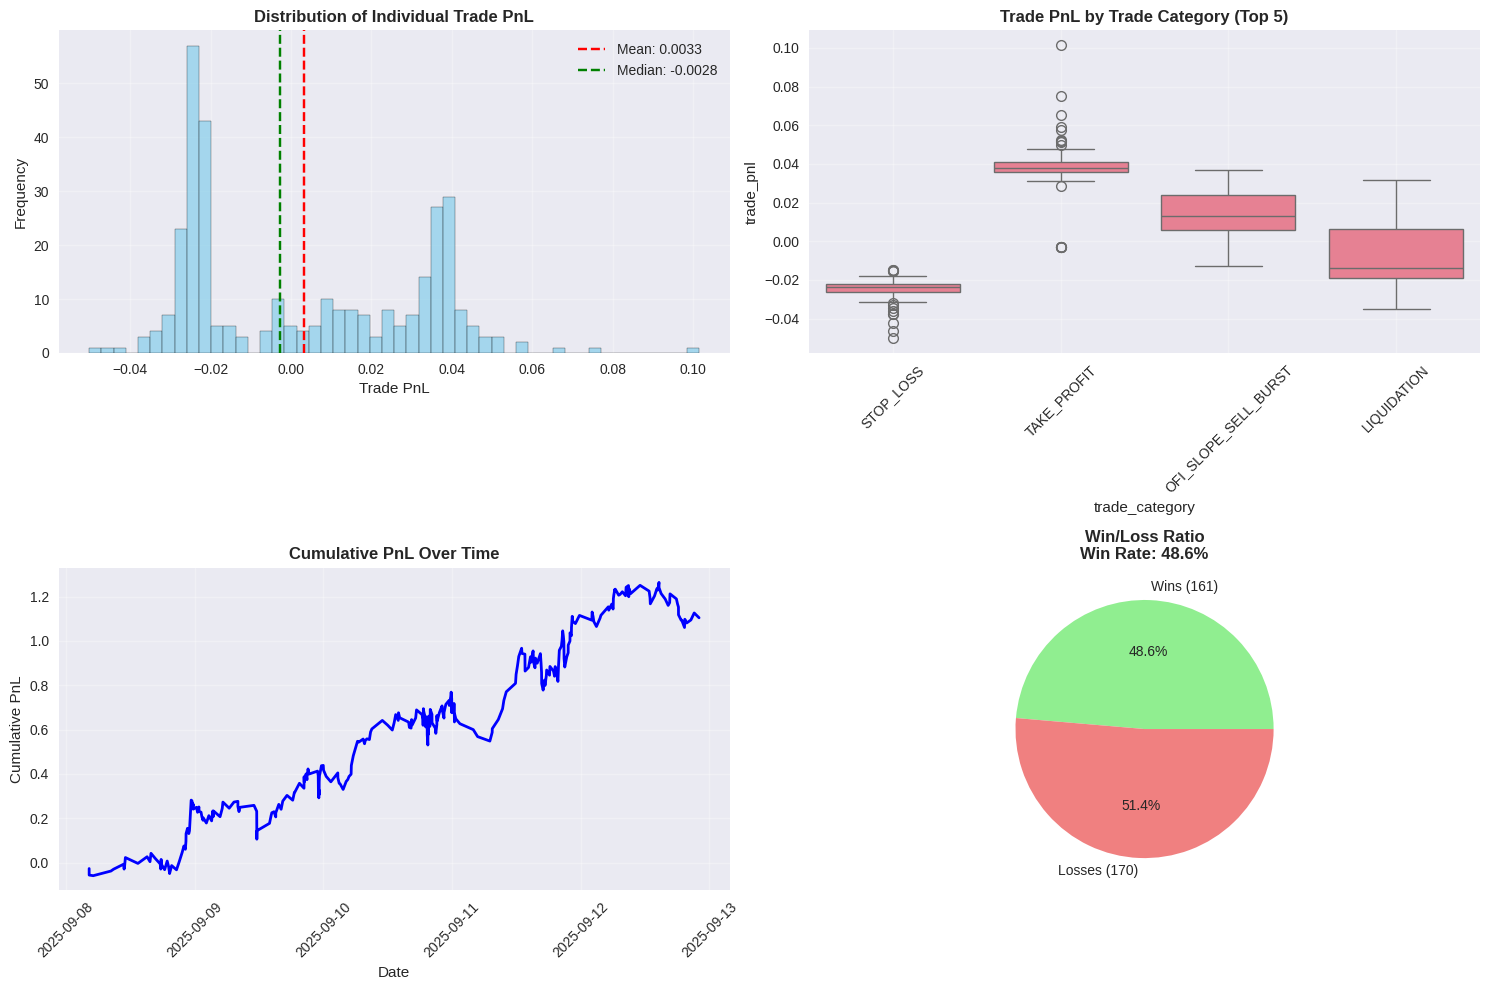

Win Rate: 48.64%
Average Win: 0.0305
Average Loss: -0.0223
Profit Factor: 1.29


In [4]:
# 2. TRADE PnL DISTRIBUTION ANALYSIS
plt.figure(figsize=(15, 10))

# Trade PnL histogram
plt.subplot(2, 2, 1)
plt.hist(df['trade_pnl'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Individual Trade PnL', fontsize=12, fontweight='bold')
plt.xlabel('Trade PnL')
plt.ylabel('Frequency')
plt.axvline(df['trade_pnl'].mean(), color='red', linestyle='--', label=f'Mean: {df["trade_pnl"].mean():.4f}')
plt.axvline(df['trade_pnl'].median(), color='green', linestyle='--', label=f'Median: {df["trade_pnl"].median():.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Box plot by trade category
plt.subplot(2, 2, 2)
trade_categories = df['trade_category'].value_counts().head(5).index
df_filtered = df[df['trade_category'].isin(trade_categories)]
sns.boxplot(data=df_filtered, x='trade_category', y='trade_pnl')
plt.title('Trade PnL by Trade Category (Top 5)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Cumulative PnL over time
plt.subplot(2, 2, 3)
plt.plot(df['exit_date'], df['cumulative_pnl'], linewidth=2, color='blue')
plt.title('Cumulative PnL Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Win/Loss analysis
plt.subplot(2, 2, 4)
wins = df[df['trade_pnl'] > 0]
losses = df[df['trade_pnl'] < 0]
win_rate = len(wins) / len(df) * 100

plt.pie([len(wins), len(losses)], labels=[f'Wins ({len(wins)})', f'Losses ({len(losses)})'], 
        autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title(f'Win/Loss Ratio\nWin Rate: {win_rate:.1f}%', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Win Rate: {win_rate:.2f}%")
print(f"Average Win: {wins['trade_pnl'].mean():.4f}")
print(f"Average Loss: {losses['trade_pnl'].mean():.4f}")
print(f"Profit Factor: {abs(wins['trade_pnl'].sum() / losses['trade_pnl'].sum()):.2f}")


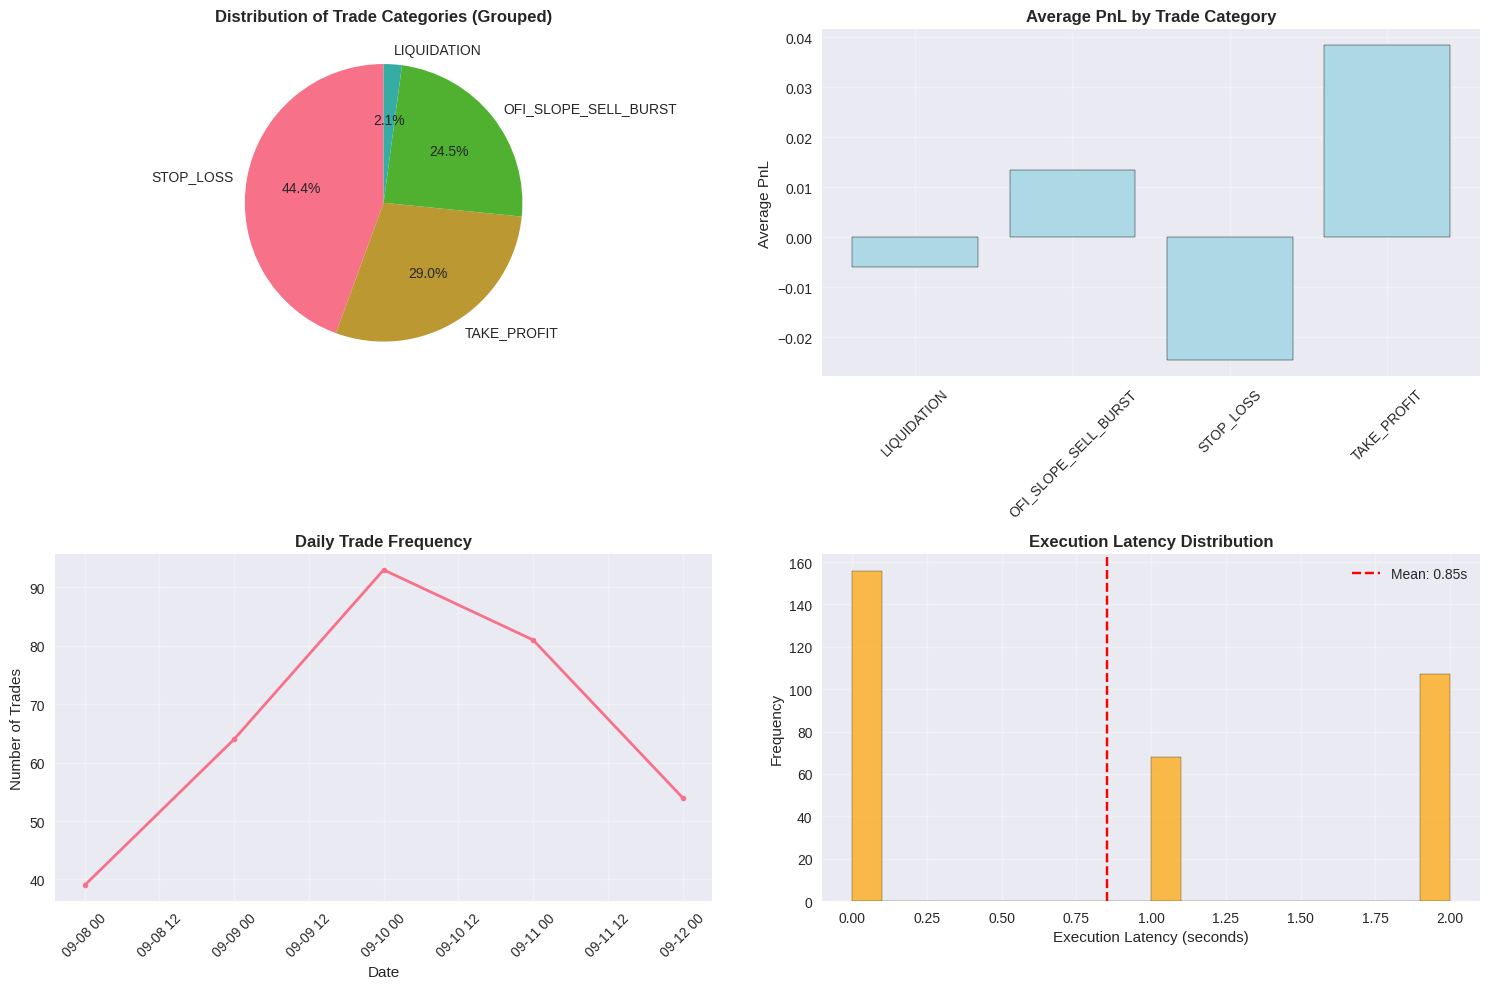

Trade Category Performance Summary:
LIQUIDATION: 7 trades, Avg PnL: -0.0060, Win Rate: 28.6%
OFI_SLOPE_SELL_BURST: 81 trades, Avg PnL: 0.0135, Win Rate: 84.0%
STOP_LOSS: 147 trades, Avg PnL: -0.0247, Win Rate: 0.0%
TAKE_PROFIT: 96 trades, Avg PnL: 0.0384, Win Rate: 94.8%


In [5]:
# 3. TRADE TYPE ANALYSIS
plt.figure(figsize=(15, 10))

# Trade category distribution (grouped)
plt.subplot(2, 2, 1)
trade_category_counts = df['trade_category'].value_counts()
plt.pie(trade_category_counts.values, labels=trade_category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Trade Categories (Grouped)', fontsize=12, fontweight='bold')

# PnL by trade category
plt.subplot(2, 2, 2)
trade_category_pnl = df.groupby('trade_category')['trade_pnl'].agg(['mean', 'count']).reset_index()
plt.bar(trade_category_pnl['trade_category'], trade_category_pnl['mean'], color='lightblue', edgecolor='black')
plt.title('Average PnL by Trade Category', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Average PnL')
plt.grid(True, alpha=0.3)

# Trade frequency over time
plt.subplot(2, 2, 3)
daily_trades = df.groupby('date').size()
plt.plot(daily_trades.index, daily_trades.values, marker='o', linewidth=2, markersize=4)
plt.title('Daily Trade Frequency', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Execution latency analysis
plt.subplot(2, 2, 4)
plt.hist(df['execution_latency_seconds'], bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Execution Latency Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Execution Latency (seconds)')
plt.ylabel('Frequency')
plt.axvline(df['execution_latency_seconds'].mean(), color='red', linestyle='--', 
           label=f'Mean: {df["execution_latency_seconds"].mean():.2f}s')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print trade category statistics
print("Trade Category Performance Summary:")
for trade_category in trade_category_pnl['trade_category']:
    subset = df[df['trade_category'] == trade_category]
    win_rate = len(subset[subset['trade_pnl'] > 0]) / len(subset) * 100
    print(f"{trade_category}: {len(subset)} trades, Avg PnL: {subset['trade_pnl'].mean():.4f}, Win Rate: {win_rate:.1f}%")


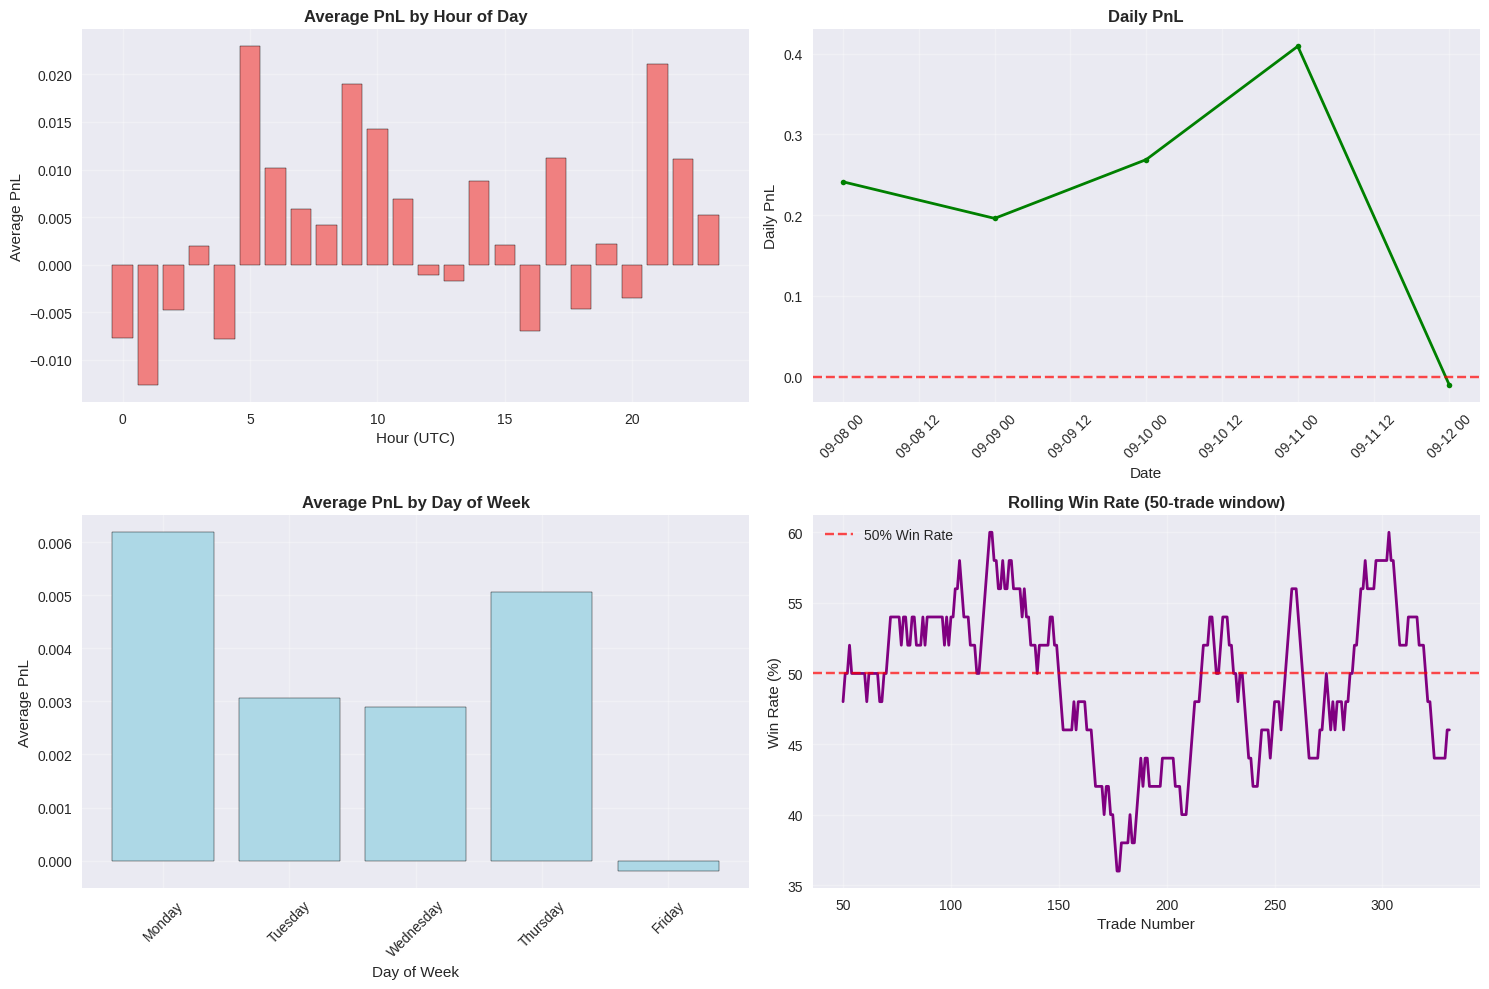

Temporal Analysis Summary:
Best performing hour: 5 UTC (Avg PnL: 0.0230)
Worst performing hour: 1 UTC (Avg PnL: -0.0127)
Best performing day: Monday (Avg PnL: 0.0062)
Worst performing day: Friday (Avg PnL: -0.0002)


In [6]:
# 4. TEMPORAL ANALYSIS
plt.figure(figsize=(15, 10))

# Hourly performance
plt.subplot(2, 2, 1)
hourly_pnl = df.groupby('hour')['trade_pnl'].mean()
plt.bar(hourly_pnl.index, hourly_pnl.values, color='lightcoral', edgecolor='black')
plt.title('Average PnL by Hour of Day', fontsize=12, fontweight='bold')
plt.xlabel('Hour (UTC)')
plt.ylabel('Average PnL')
plt.grid(True, alpha=0.3)

# Daily performance
plt.subplot(2, 2, 2)
daily_pnl = df.groupby('date')['trade_pnl'].sum()
plt.plot(daily_pnl.index, daily_pnl.values, marker='o', linewidth=2, markersize=4, color='green')
plt.title('Daily PnL', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily PnL')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# Day of week performance
plt.subplot(2, 2, 3)
dow_pnl = df.groupby('day_of_week')['trade_pnl'].mean()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_pnl = dow_pnl.reindex(dow_order)
plt.bar(dow_pnl.index, dow_pnl.values, color='lightblue', edgecolor='black')
plt.title('Average PnL by Day of Week', fontsize=12, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Average PnL')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Rolling performance metrics
plt.subplot(2, 2, 4)
window = 50
rolling_win_rate = df['trade_pnl'].rolling(window=window).apply(lambda x: (x > 0).mean() * 100)
plt.plot(df['trade_number'], rolling_win_rate, linewidth=2, color='purple')
plt.title(f'Rolling Win Rate ({window}-trade window)', fontsize=12, fontweight='bold')
plt.xlabel('Trade Number')
plt.ylabel('Win Rate (%)')
plt.grid(True, alpha=0.3)
plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% Win Rate')
plt.legend()

plt.tight_layout()
plt.show()

# Print temporal statistics
print("Temporal Analysis Summary:")
print(f"Best performing hour: {hourly_pnl.idxmax()} UTC (Avg PnL: {hourly_pnl.max():.4f})")
print(f"Worst performing hour: {hourly_pnl.idxmin()} UTC (Avg PnL: {hourly_pnl.min():.4f})")
print(f"Best performing day: {dow_pnl.idxmax()} (Avg PnL: {dow_pnl.max():.4f})")
print(f"Worst performing day: {dow_pnl.idxmin()} (Avg PnL: {dow_pnl.min():.4f})")


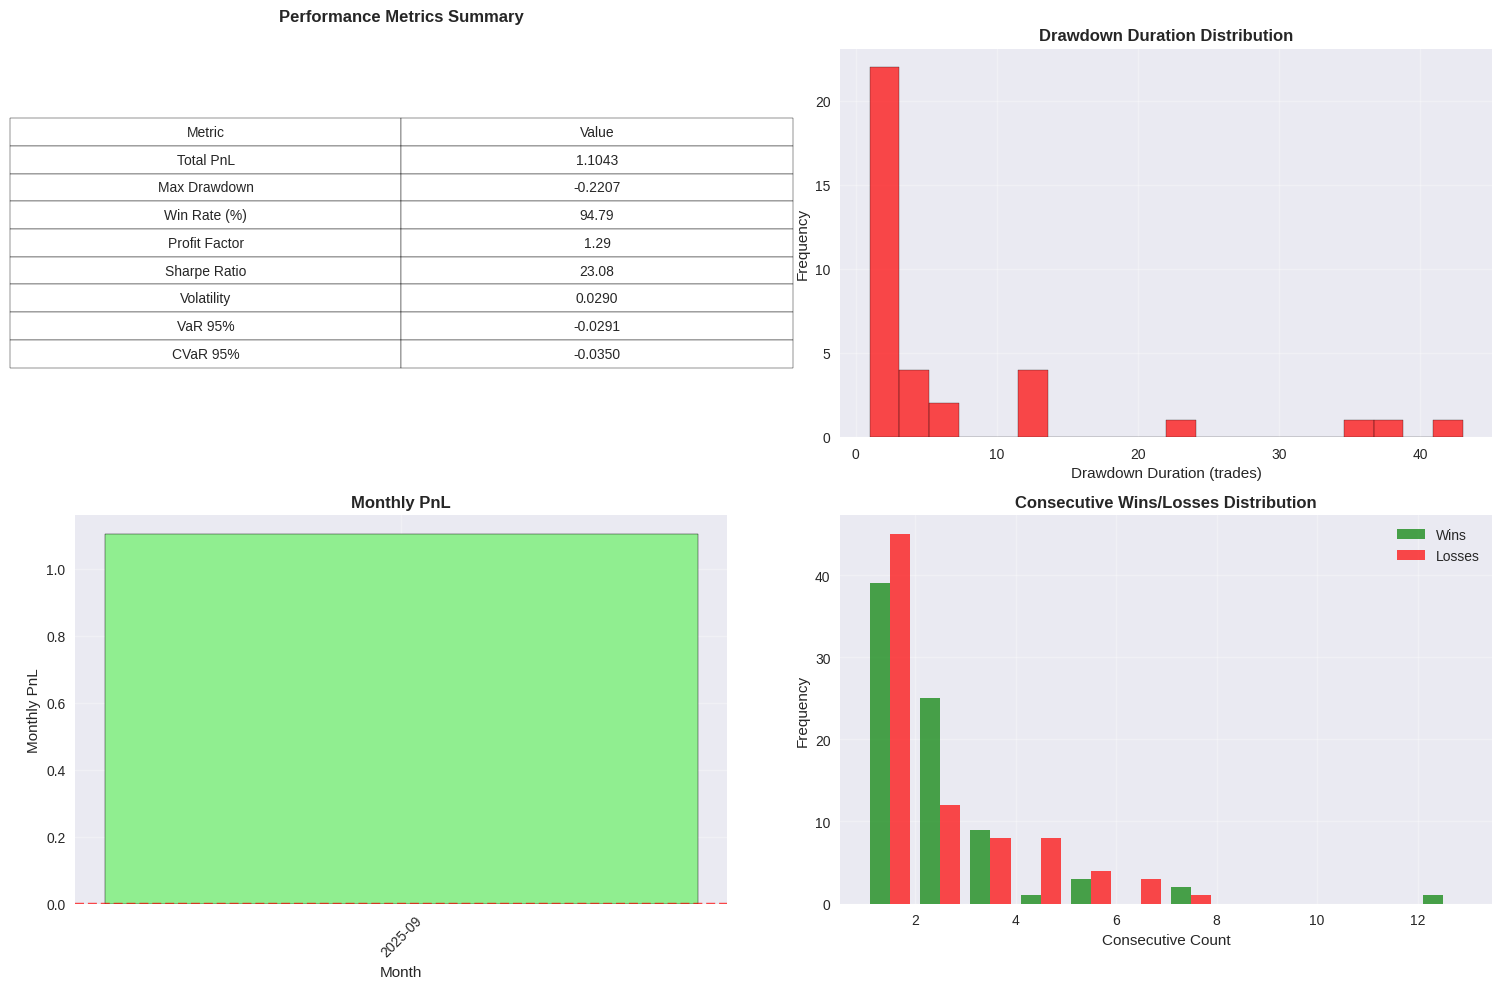


Risk Metrics Summary:
Sharpe Ratio: 23.08
Maximum Drawdown: -0.2207
Value at Risk (95%): -0.0291
Conditional Value at Risk (95%): -0.0350
Volatility: 0.0290


In [7]:
# 5. RISK METRICS AND PERFORMANCE STATISTICS
plt.figure(figsize=(15, 10))

# Sharpe ratio calculation (assuming daily returns)
daily_returns = df.groupby('date')['trade_pnl'].sum()
sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() > 0 else 0

# Risk metrics
max_drawdown = drawdown.min()
max_drawdown_duration = (drawdown == 0).cumsum().groupby((drawdown != 0).cumsum()).max().max()
volatility = df['trade_pnl'].std()
var_95 = np.percentile(df['trade_pnl'], 5)
cvar_95 = df[df['trade_pnl'] <= var_95]['trade_pnl'].mean()

# Performance metrics table
plt.subplot(2, 2, 1)
metrics_data = {
    'Metric': ['Total PnL', 'Max Drawdown', 'Win Rate (%)', 'Profit Factor', 
               'Sharpe Ratio', 'Volatility', 'VaR 95%', 'CVaR 95%'],
    'Value': [f"{final_pnl:.4f}", f"{max_drawdown:.4f}", f"{win_rate:.2f}",
              f"{abs(wins['trade_pnl'].sum() / losses['trade_pnl'].sum()):.2f}",
              f"{sharpe_ratio:.2f}", f"{volatility:.4f}", f"{var_95:.4f}", f"{cvar_95:.4f}"]
}
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=list(zip(metrics_data['Metric'], metrics_data['Value'])),
                 colLabels=['Metric', 'Value'],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.title('Performance Metrics Summary', fontsize=12, fontweight='bold', pad=20)

# Drawdown duration analysis
plt.subplot(2, 2, 2)
drawdown_periods = (drawdown < 0).astype(int)
drawdown_starts = drawdown_periods.diff() == 1
drawdown_durations = []
current_duration = 0
for i, is_drawdown in enumerate(drawdown_periods):
    if is_drawdown:
        current_duration += 1
    else:
        if current_duration > 0:
            drawdown_durations.append(current_duration)
            current_duration = 0

if drawdown_durations:
    plt.hist(drawdown_durations, bins=20, alpha=0.7, color='red', edgecolor='black')
    plt.title('Drawdown Duration Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Drawdown Duration (trades)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No significant drawdowns', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Drawdown Duration Distribution', fontsize=12, fontweight='bold')

# Monthly performance
plt.subplot(2, 2, 3)
df['month'] = df['exit_date'].dt.to_period('M')
monthly_pnl = df.groupby('month')['trade_pnl'].sum()
plt.bar(range(len(monthly_pnl)), monthly_pnl.values, color='lightgreen', edgecolor='black')
plt.title('Monthly PnL', fontsize=12, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Monthly PnL')
plt.xticks(range(len(monthly_pnl)), [str(m) for m in monthly_pnl.index], rotation=45)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# Consecutive wins/losses
plt.subplot(2, 2, 4)
consecutive_wins = []
consecutive_losses = []
current_wins = 0
current_losses = 0

for pnl in df['trade_pnl']:
    if pnl > 0:
        current_wins += 1
        if current_losses > 0:
            consecutive_losses.append(current_losses)
            current_losses = 0
    else:
        current_losses += 1
        if current_wins > 0:
            consecutive_wins.append(current_wins)
            current_wins = 0

if current_wins > 0:
    consecutive_wins.append(current_wins)
if current_losses > 0:
    consecutive_losses.append(current_losses)

plt.hist([consecutive_wins, consecutive_losses], bins=range(1, max(max(consecutive_wins, default=0), 
                                                                  max(consecutive_losses, default=0)) + 2),
         alpha=0.7, label=['Wins', 'Losses'], color=['green', 'red'])
plt.title('Consecutive Wins/Losses Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Consecutive Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRisk Metrics Summary:")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")
print(f"Value at Risk (95%): {var_95:.4f}")
print(f"Conditional Value at Risk (95%): {cvar_95:.4f}")
print(f"Volatility: {volatility:.4f}")


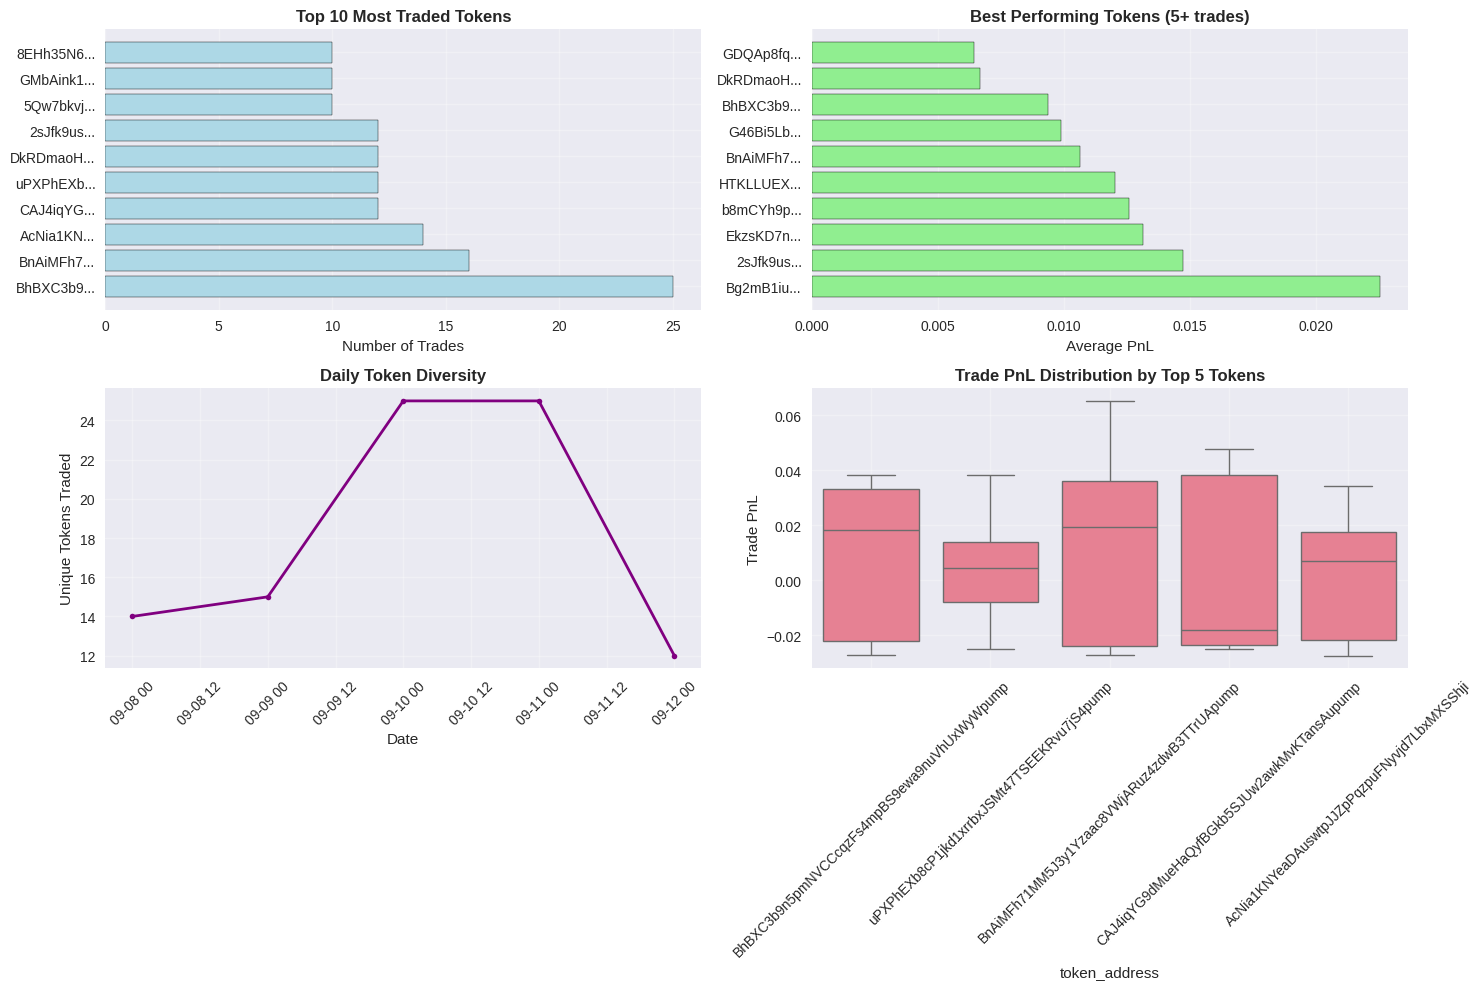

Token Analysis Summary:
Total unique tokens traded: 64
Average trades per token: 5.2
Most traded token: BhBXC3b9... (25 trades)
Best performing token (5+ trades): Bg2mB1iu... (Avg PnL: 0.0225)


In [8]:
# 6. TOKEN-SPECIFIC ANALYSIS
plt.figure(figsize=(15, 10))

# Most traded tokens
plt.subplot(2, 2, 1)
token_counts = df['token_address'].value_counts().head(10)
plt.barh(range(len(token_counts)), token_counts.values, color='lightblue', edgecolor='black')
plt.yticks(range(len(token_counts)), [addr[:8] + '...' for addr in token_counts.index])
plt.title('Top 10 Most Traded Tokens', fontsize=12, fontweight='bold')
plt.xlabel('Number of Trades')
plt.grid(True, alpha=0.3)

# Token performance (only tokens with 5+ trades)
plt.subplot(2, 2, 2)
token_pnl = df.groupby('token_address')['trade_pnl'].agg(['mean', 'count']).reset_index()
token_pnl = token_pnl[token_pnl['count'] >= 5].sort_values('mean', ascending=False).head(10)
plt.barh(range(len(token_pnl)), token_pnl['mean'], color='lightgreen', edgecolor='black')
plt.yticks(range(len(token_pnl)), [addr[:8] + '...' for addr in token_pnl['token_address']])
plt.title('Best Performing Tokens (5+ trades)', fontsize=12, fontweight='bold')
plt.xlabel('Average PnL')
plt.grid(True, alpha=0.3)

# Token diversity over time
plt.subplot(2, 2, 3)
daily_unique_tokens = df.groupby('date')['token_address'].nunique()
plt.plot(daily_unique_tokens.index, daily_unique_tokens.values, marker='o', linewidth=2, markersize=4, color='purple')
plt.title('Daily Token Diversity', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Unique Tokens Traded')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Trade size distribution by token (using trade_pnl as proxy for size)
plt.subplot(2, 2, 4)
top_tokens = df['token_address'].value_counts().head(5).index
df_top_tokens = df[df['token_address'].isin(top_tokens)]
sns.boxplot(data=df_top_tokens, x='token_address', y='trade_pnl')
plt.title('Trade PnL Distribution by Top 5 Tokens', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Trade PnL')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print token statistics
print("Token Analysis Summary:")
print(f"Total unique tokens traded: {df['token_address'].nunique()}")
print(f"Average trades per token: {len(df) / df['token_address'].nunique():.1f}")
print(f"Most traded token: {token_counts.index[0][:8]}... ({token_counts.iloc[0]} trades)")
print(f"Best performing token (5+ trades): {token_pnl.iloc[0]['token_address'][:8]}... (Avg PnL: {token_pnl.iloc[0]['mean']:.4f})")


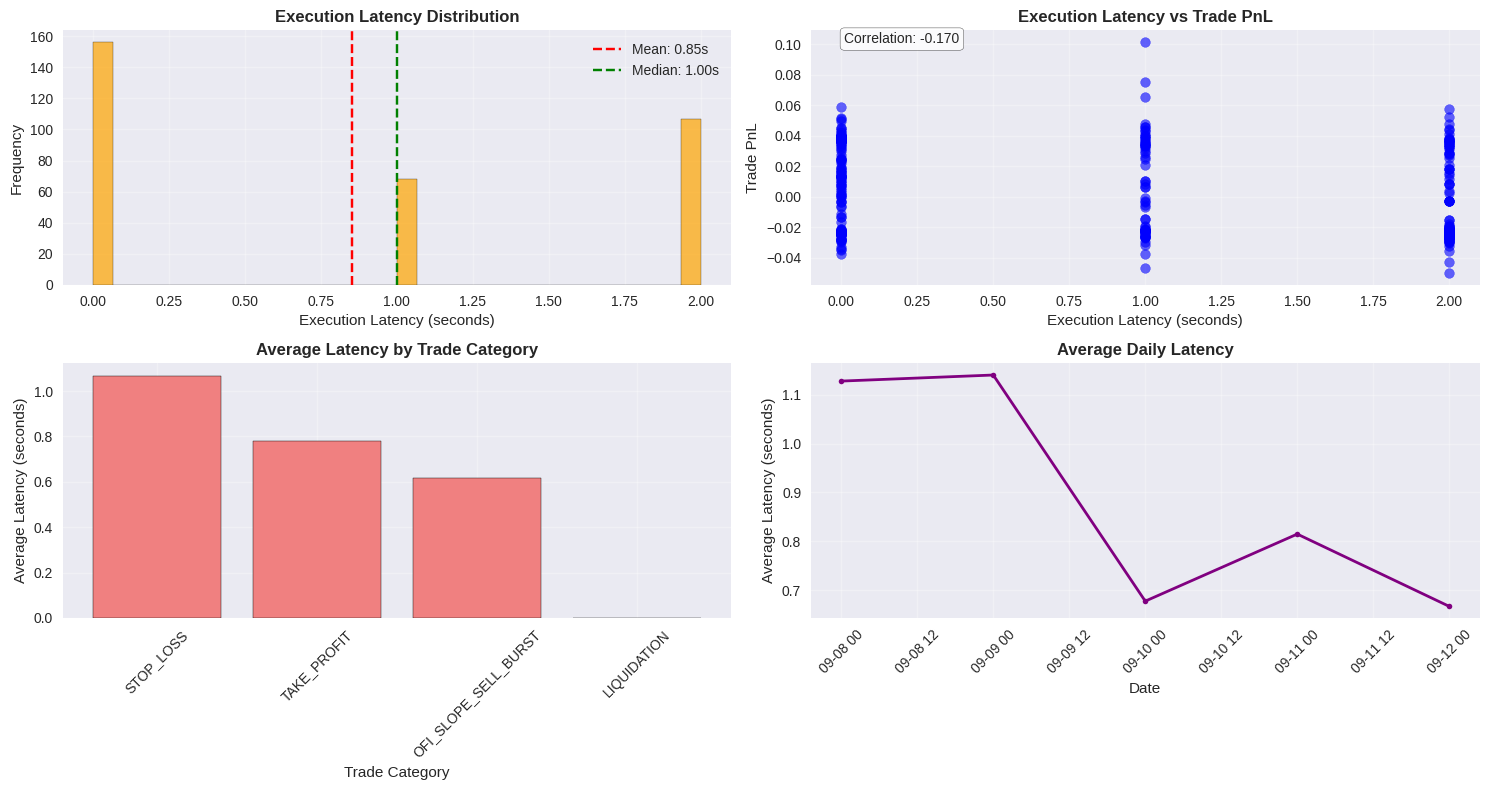

Execution Latency Analysis:
Mean latency: 0.85 seconds
Median latency: 1.00 seconds
Min latency: 0.00 seconds
Max latency: 2.00 seconds
Standard deviation: 0.88 seconds
Correlation with PnL: -0.170


In [9]:
# 7. EXECUTION LATENCY ANALYSIS
plt.figure(figsize=(15, 8))

# Latency distribution
plt.subplot(2, 2, 1)
plt.hist(df['execution_latency_seconds'], bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Execution Latency Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Execution Latency (seconds)')
plt.ylabel('Frequency')
plt.axvline(df['execution_latency_seconds'].mean(), color='red', linestyle='--', 
           label=f'Mean: {df["execution_latency_seconds"].mean():.2f}s')
plt.axvline(df['execution_latency_seconds'].median(), color='green', linestyle='--', 
           label=f'Median: {df["execution_latency_seconds"].median():.2f}s')
plt.legend()
plt.grid(True, alpha=0.3)

# Latency vs PnL correlation
plt.subplot(2, 2, 2)
plt.scatter(df['execution_latency_seconds'], df['trade_pnl'], alpha=0.6, color='blue')
plt.title('Execution Latency vs Trade PnL', fontsize=12, fontweight='bold')
plt.xlabel('Execution Latency (seconds)')
plt.ylabel('Trade PnL')
plt.grid(True, alpha=0.3)

# Add correlation coefficient
correlation = df['execution_latency_seconds'].corr(df['trade_pnl'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Latency by trade category
plt.subplot(2, 2, 3)
latency_by_category = df.groupby('trade_category')['execution_latency_seconds'].mean().sort_values(ascending=False)
plt.bar(range(len(latency_by_category)), latency_by_category.values, color='lightcoral', edgecolor='black')
plt.title('Average Latency by Trade Category', fontsize=12, fontweight='bold')
plt.xlabel('Trade Category')
plt.ylabel('Average Latency (seconds)')
plt.xticks(range(len(latency_by_category)), latency_by_category.index, rotation=45)
plt.grid(True, alpha=0.3)

# Latency over time
plt.subplot(2, 2, 4)
daily_latency = df.groupby('date')['execution_latency_seconds'].mean()
plt.plot(daily_latency.index, daily_latency.values, marker='o', linewidth=2, markersize=4, color='purple')
plt.title('Average Daily Latency', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Average Latency (seconds)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print latency statistics
print("Execution Latency Analysis:")
print(f"Mean latency: {df['execution_latency_seconds'].mean():.2f} seconds")
print(f"Median latency: {df['execution_latency_seconds'].median():.2f} seconds")
print(f"Min latency: {df['execution_latency_seconds'].min():.2f} seconds")
print(f"Max latency: {df['execution_latency_seconds'].max():.2f} seconds")
print(f"Standard deviation: {df['execution_latency_seconds'].std():.2f} seconds")
print(f"Correlation with PnL: {correlation:.3f}")


In [10]:
# 8. SUMMARY AND RECOMMENDATIONS
print("="*80)
print("EQUITY CURVE ANALYSIS SUMMARY")
print("="*80)

# Overall performance
print(f"\n📊 OVERALL PERFORMANCE:")
print(f"   • Total Trades: {len(df):,}")
print(f"   • Final PnL: {final_pnl:.4f}")
print(f"   • Win Rate: {win_rate:.2f}%")
print(f"   • Profit Factor: {abs(wins['trade_pnl'].sum() / losses['trade_pnl'].sum()):.2f}")

# Risk metrics
print(f"\n⚠️  RISK METRICS:")
print(f"   • Maximum Drawdown: {max_drawdown:.4f}")
print(f"   • Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"   • Volatility: {volatility:.4f}")
print(f"   • VaR (95%): {var_95:.4f}")

# Trade category analysis
print(f"\n📈 TRADE CATEGORY PERFORMANCE:")
best_category = trade_category_pnl.loc[trade_category_pnl['mean'].idxmax()]
worst_category = trade_category_pnl.loc[trade_category_pnl['mean'].idxmin()]
print(f"   • Best performing category: {best_category['trade_category']} (Avg PnL: {best_category['mean']:.4f})")
print(f"   • Worst performing category: {worst_category['trade_category']} (Avg PnL: {worst_category['mean']:.4f})")

# Temporal patterns
print(f"\n🕐 TEMPORAL PATTERNS:")
print(f"   • Best hour: {hourly_pnl.idxmax()} UTC (Avg PnL: {hourly_pnl.max():.4f})")
print(f"   • Best day: {dow_pnl.idxmax()} (Avg PnL: {dow_pnl.max():.4f})")
print(f"   • Average daily trades: {len(df) / len(daily_trades):.1f}")

# Token analysis
print(f"\n🪙 TOKEN ANALYSIS:")
print(f"   • Unique tokens traded: {df['token_address'].nunique()}")
print(f"   • Most traded token: {token_counts.index[0][:8]}... ({token_counts.iloc[0]} trades)")
print(f"   • Token diversity (avg daily): {daily_unique_tokens.mean():.1f}")

# Execution analysis
print(f"\n⚡ EXECUTION ANALYSIS:")
print(f"   • Average latency: {df['execution_latency_seconds'].mean():.2f}s")
print(f"   • Latency-PnL correlation: {correlation:.3f}")

print(f"\n💡 RECOMMENDATIONS:")
if win_rate < 50:
    print("   • Consider improving entry/exit criteria to increase win rate")
if max_drawdown < -0.1:
    print("   • Implement better risk management to reduce drawdowns")
if sharpe_ratio < 1.0:
    print("   • Focus on improving risk-adjusted returns")
if correlation < -0.1:
    print("   • Investigate latency impact on performance")
if daily_unique_tokens.mean() < 10:
    print("   • Consider diversifying across more tokens")

print("\n" + "="*80)


EQUITY CURVE ANALYSIS SUMMARY

📊 OVERALL PERFORMANCE:
   • Total Trades: 331
   • Final PnL: 1.1043
   • Win Rate: 94.79%
   • Profit Factor: 1.29

⚠️  RISK METRICS:
   • Maximum Drawdown: -0.2207
   • Sharpe Ratio: 23.08
   • Volatility: 0.0290
   • VaR (95%): -0.0291

📈 TRADE CATEGORY PERFORMANCE:
   • Best performing category: TAKE_PROFIT (Avg PnL: 0.0384)
   • Worst performing category: STOP_LOSS (Avg PnL: -0.0247)

🕐 TEMPORAL PATTERNS:
   • Best hour: 5 UTC (Avg PnL: 0.0230)
   • Best day: Monday (Avg PnL: 0.0062)
   • Average daily trades: 66.2

🪙 TOKEN ANALYSIS:
   • Unique tokens traded: 64
   • Most traded token: BhBXC3b9... (25 trades)
   • Token diversity (avg daily): 18.2

⚡ EXECUTION ANALYSIS:
   • Average latency: 0.85s
   • Latency-PnL correlation: -0.170

💡 RECOMMENDATIONS:
   • Implement better risk management to reduce drawdowns
   • Investigate latency impact on performance



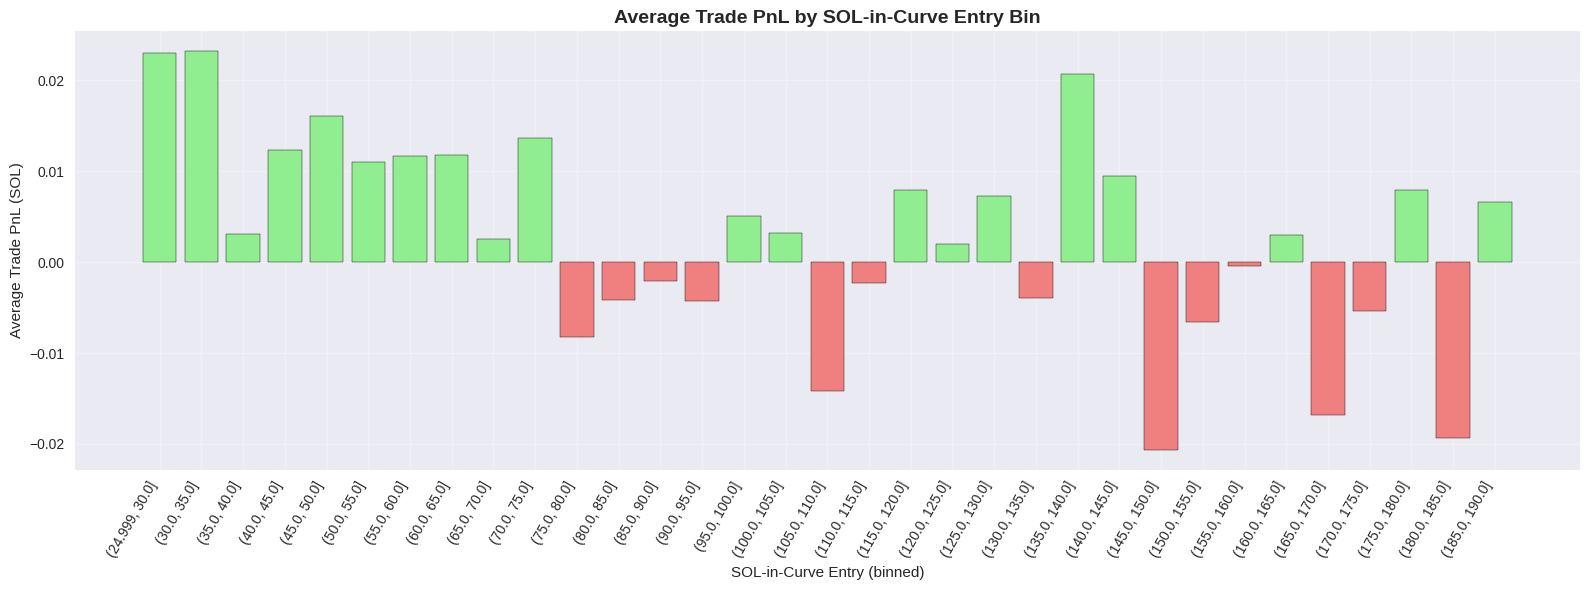

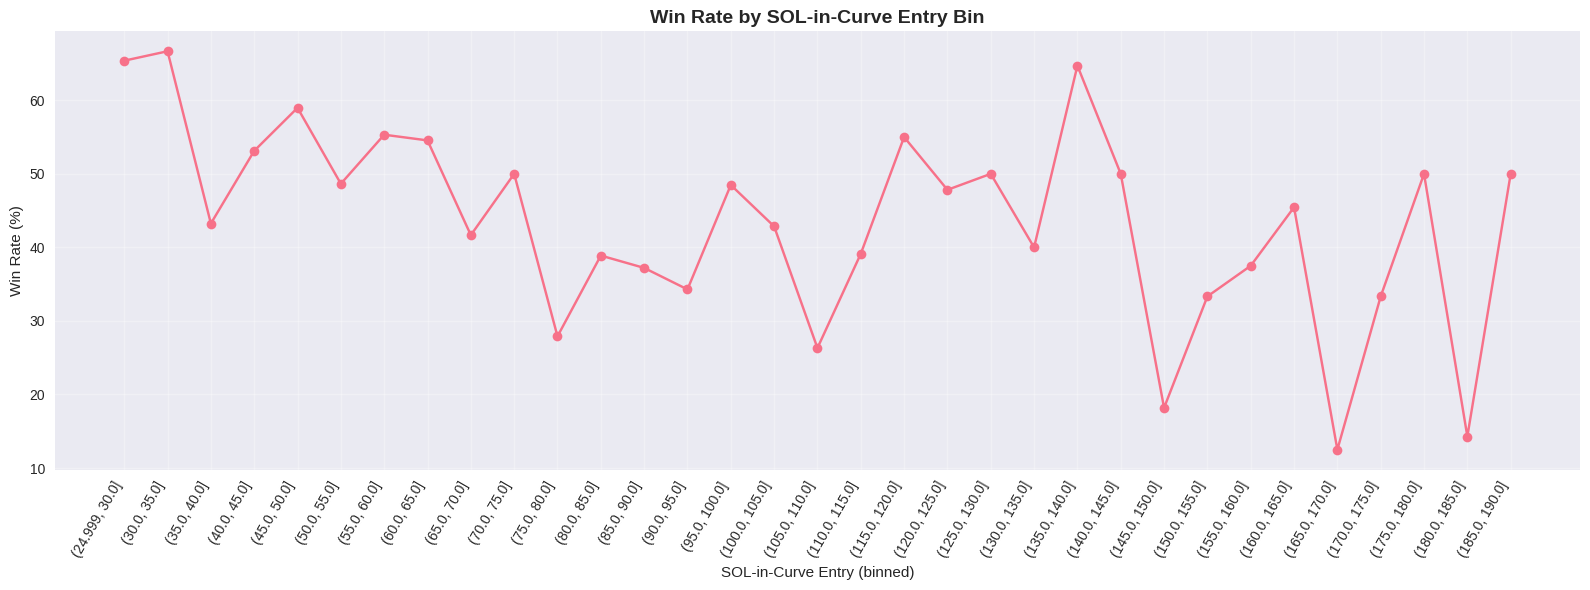

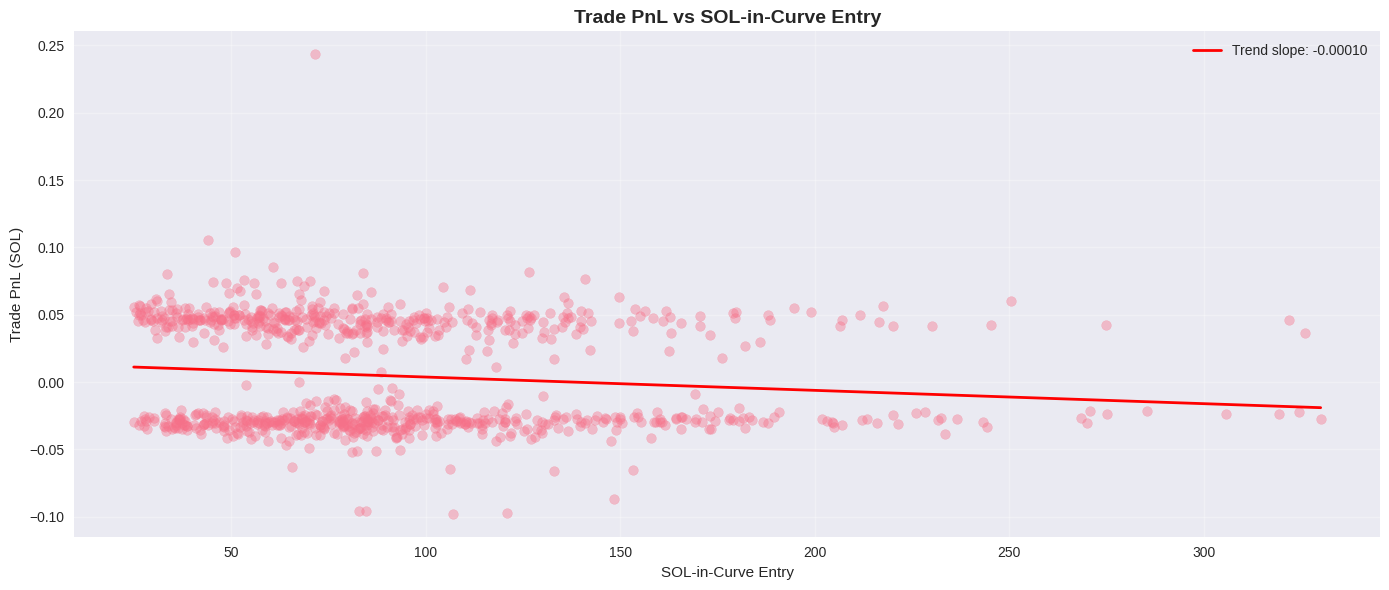


Top 10 SOL-in-Curve Entry Bins by Average PnL:


,sol_entry_bin,trades,avg_pnl,win_rate
1,"(30.0, 35.0]",33,0.023191,66.666667
0,"(24.999, 30.0]",26,0.023050,65.384615
22,"(135.0, 140.0]",17,0.020641,64.705882
4,"(45.0, 50.0]",39,0.016115,58.974359
9,"(70.0, 75.0]",50,0.013614,50.000000
3,"(40.0, 45.0]",32,0.012372,53.125000
7,"(60.0, 65.0]",44,0.011820,54.545455
6,"(55.0, 60.0]",47,0.011702,55.319149
5,"(50.0, 55.0]",37,0.011038,48.648649
23,"(140.0, 145.0]",12,0.009517,50.000000



Top 10 SOL-in-Curve Entry Bins by Win Rate:


,sol_entry_bin,trades,avg_pnl,win_rate
1,"(30.0, 35.0]",33,0.023191,66.666667
0,"(24.999, 30.0]",26,0.023050,65.384615
22,"(135.0, 140.0]",17,0.020641,64.705882
4,"(45.0, 50.0]",39,0.016115,58.974359
6,"(55.0, 60.0]",47,0.011702,55.319149
18,"(115.0, 120.0]",20,0.007895,55.000000
7,"(60.0, 65.0]",44,0.011820,54.545455
3,"(40.0, 45.0]",32,0.012372,53.125000
30,"(175.0, 180.0]",8,0.007938,50.000000
23,"(140.0, 145.0]",12,0.009517,50.000000


In [120]:
# 10. SOL-IN-CURVE ENTRY PROFITABILITY ANALYSIS
# Ensure new columns are available
required_cols = {'sol_in_curve_entry', 'sol_in_curve_exit'}
missing = required_cols - set(df.columns)
if missing:
    print(f"Missing columns in equity CSV: {missing}. Please regenerate equity CSVs with the latest code.")
else:
    # Choose bin size dynamically based on range (default 5 SOL steps; smaller if tight range)
    sol_min = float(np.floor(df['sol_in_curve_entry'].min()))
    sol_max = float(np.ceil(df['sol_in_curve_entry'].max()))
    span = max(sol_max - sol_min, 1.0)
    step = 5.0 if span > 50 else (2.0 if span > 20 else 1.0)
    bins = np.arange(sol_min - (sol_min % step), sol_max + step, step)

    # Assign bins
    df['sol_entry_bin'] = pd.cut(df['sol_in_curve_entry'], bins=bins, include_lowest=True)

    # Aggregate performance by entry bin
    grouped = df.groupby('sol_entry_bin').agg(
        trades=('trade_pnl', 'count'),
        avg_pnl=('trade_pnl', 'mean'),
        win_rate=('trade_pnl', lambda x: (x > 0).mean() * 100)
    ).reset_index()

    # Keep bins with at least a minimal sample size
    min_trades = max(5, int(len(df) * 0.005))
    grouped_filtered = grouped[grouped['trades'] >= min_trades]

    # Plot average PnL by entry bin
    plt.figure(figsize=(16, 6))
    plt.bar(grouped_filtered['sol_entry_bin'].astype(str), grouped_filtered['avg_pnl'],
            color=np.where(grouped_filtered['avg_pnl'] >= 0, 'lightgreen', 'lightcoral'), edgecolor='black')
    plt.xticks(rotation=60, ha='right')
    plt.title('Average Trade PnL by SOL-in-Curve Entry Bin', fontsize=14, fontweight='bold')
    plt.xlabel('SOL-in-Curve Entry (binned)')
    plt.ylabel('Average Trade PnL (SOL)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot win rate by entry bin
    plt.figure(figsize=(16, 6))
    plt.plot(grouped_filtered['sol_entry_bin'].astype(str), grouped_filtered['win_rate'], marker='o')
    plt.xticks(rotation=60, ha='right')
    plt.title('Win Rate by SOL-in-Curve Entry Bin', fontsize=14, fontweight='bold')
    plt.xlabel('SOL-in-Curve Entry (binned)')
    plt.ylabel('Win Rate (%)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Scatter: entry value vs trade PnL
    plt.figure(figsize=(14, 6))
    plt.scatter(df['sol_in_curve_entry'], df['trade_pnl'], alpha=0.4)
    z = np.polyfit(df['sol_in_curve_entry'], df['trade_pnl'], 1)
    p = np.poly1d(z)
    xs = np.linspace(df['sol_in_curve_entry'].min(), df['sol_in_curve_entry'].max(), 200)
    plt.plot(xs, p(xs), color='red', linewidth=2, label=f'Trend slope: {z[0]:.5f}')
    plt.title('Trade PnL vs SOL-in-Curve Entry', fontsize=14, fontweight='bold')
    plt.xlabel('SOL-in-Curve Entry')
    plt.ylabel('Trade PnL (SOL)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print top bins by profitability and win rate
    top_avg = grouped_filtered.sort_values('avg_pnl', ascending=False).head(10)
    top_win = grouped_filtered.sort_values('win_rate', ascending=False).head(10)

    print('\nTop 10 SOL-in-Curve Entry Bins by Average PnL:')
    display(top_avg)

    print('\nTop 10 SOL-in-Curve Entry Bins by Win Rate:')
    display(top_win)



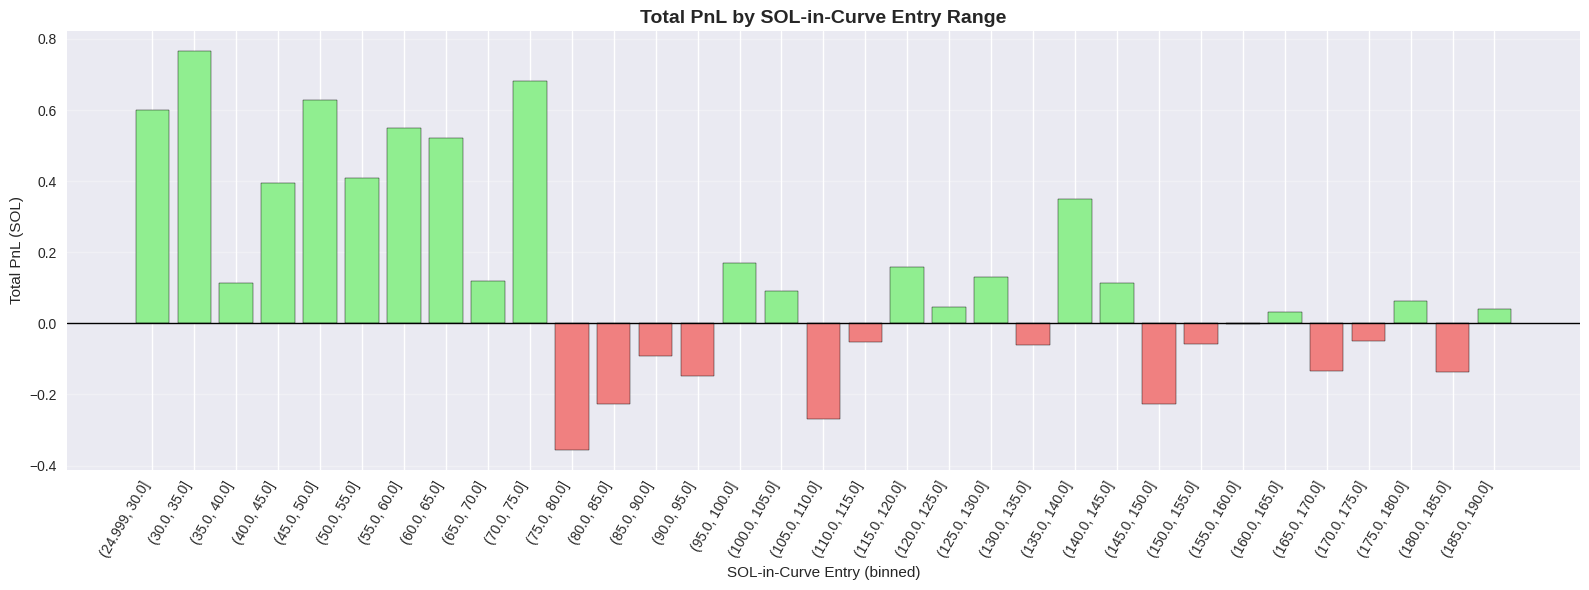

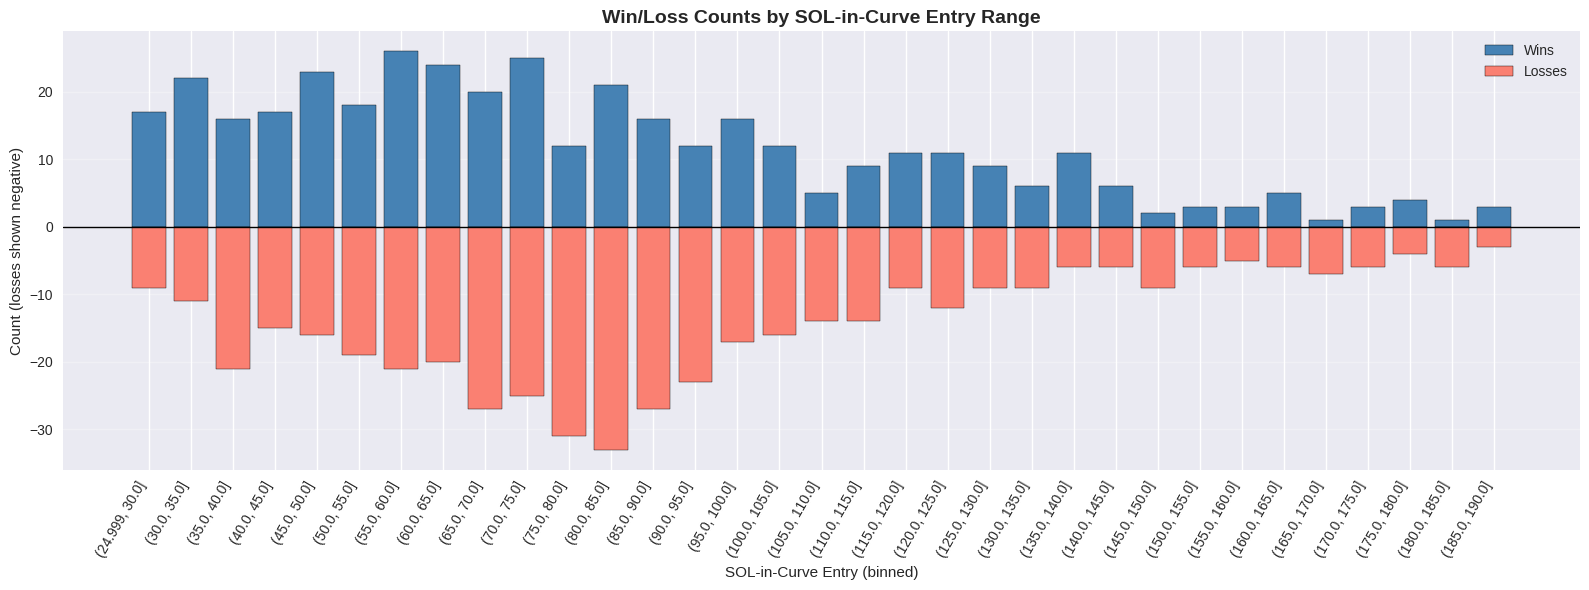


Top 10 SOL-in-Curve Entry Ranges by Total PnL:


,sol_entry_bin,trades,total_pnl,avg_pnl,wins,losses
1,"(30.0, 35.0]",33,0.7653,0.023191,22,11
9,"(70.0, 75.0]",50,0.6807,0.013614,25,25
4,"(45.0, 50.0]",39,0.6285,0.016115,23,16
0,"(24.999, 30.0]",26,0.5993,0.023050,17,9
6,"(55.0, 60.0]",47,0.5500,0.011702,26,21
7,"(60.0, 65.0]",44,0.5201,0.011820,24,20
5,"(50.0, 55.0]",37,0.4084,0.011038,18,19
3,"(40.0, 45.0]",32,0.3959,0.012372,17,15
22,"(135.0, 140.0]",17,0.3509,0.020641,11,6
14,"(95.0, 100.0]",33,0.1691,0.005124,16,17



Top 10 SOL-in-Curve Entry Ranges by Total Loss (Most Negative PnL):


,sol_entry_bin,trades,total_pnl,avg_pnl,wins,losses
10,"(75.0, 80.0]",43,-0.3552,-0.008260,12,31
16,"(105.0, 110.0]",19,-0.2701,-0.014216,5,14
24,"(145.0, 150.0]",11,-0.2269,-0.020627,2,9
11,"(80.0, 85.0]",54,-0.2256,-0.004178,21,33
13,"(90.0, 95.0]",35,-0.1486,-0.004246,12,23
31,"(180.0, 185.0]",7,-0.1355,-0.019357,1,6
28,"(165.0, 170.0]",8,-0.1349,-0.016862,1,7
12,"(85.0, 90.0]",43,-0.0911,-0.002119,16,27
21,"(130.0, 135.0]",15,-0.0599,-0.003993,6,9
25,"(150.0, 155.0]",9,-0.0593,-0.006589,3,6


In [121]:
# 11. PROFIT/LOSS BY SOL-IN-CURVE ENTRY RANGE
required_cols = {'sol_in_curve_entry'}
missing = required_cols - set(df.columns)
if missing:
    print(f"Missing columns in equity CSV: {missing}. Please regenerate equity CSVs with the latest code.")
else:
    # Ensure bins exist; if not, create them
    if 'sol_entry_bin' not in df.columns:
        sol_min = float(np.floor(df['sol_in_curve_entry'].min()))
        sol_max = float(np.ceil(df['sol_in_curve_entry'].max()))
        span = max(sol_max - sol_min, 1.0)
        step = 5.0 if span > 50 else (2.0 if span > 20 else 1.0)
        bins = np.arange(sol_min - (sol_min % step), sol_max + step, step)
        df['sol_entry_bin'] = pd.cut(df['sol_in_curve_entry'], bins=bins, include_lowest=True)

    # Aggregate metrics per bin
    agg = df.groupby('sol_entry_bin').agg(
        trades=('trade_pnl', 'count'),
        total_pnl=('trade_pnl', 'sum'),
        avg_pnl=('trade_pnl', 'mean'),
        wins=('trade_pnl', lambda x: (x > 0).sum()),
        losses=('trade_pnl', lambda x: (x < 0).sum())
    ).reset_index()

    # Filter out bins with very few trades
    min_trades = max(5, int(len(df) * 0.005))
    agg_f = agg[agg['trades'] >= min_trades].copy()

    # Sort bins by their left edge for consistent plotting
    # (convert interval to numeric midpoint for sorting)
    agg_f['bin_mid'] = agg_f['sol_entry_bin'].apply(lambda iv: (iv.left + iv.right) / 2 if pd.notnull(iv) else np.nan)
    agg_f = agg_f.sort_values('bin_mid')

    # Plot 1: Diverging bar of total PnL by entry bin
    plt.figure(figsize=(16, 6))
    colors = np.where(agg_f['total_pnl'] >= 0, 'lightgreen', 'lightcoral')
    plt.bar(agg_f['sol_entry_bin'].astype(str), agg_f['total_pnl'], color=colors, edgecolor='black')
    plt.xticks(rotation=60, ha='right')
    plt.title('Total PnL by SOL-in-Curve Entry Range', fontsize=14, fontweight='bold')
    plt.xlabel('SOL-in-Curve Entry (binned)')
    plt.ylabel('Total PnL (SOL)')
    plt.axhline(0, color='black', linewidth=1)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 2: Wins and losses by entry bin (diverging)
    plt.figure(figsize=(16, 6))
    plt.bar(agg_f['sol_entry_bin'].astype(str), agg_f['wins'], color='steelblue', edgecolor='black', label='Wins')
    plt.bar(agg_f['sol_entry_bin'].astype(str), -agg_f['losses'], color='salmon', edgecolor='black', label='Losses')
    plt.xticks(rotation=60, ha='right')
    plt.title('Win/Loss Counts by SOL-in-Curve Entry Range', fontsize=14, fontweight='bold')
    plt.xlabel('SOL-in-Curve Entry (binned)')
    plt.ylabel('Count (losses shown negative)')
    plt.axhline(0, color='black', linewidth=1)
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print top profit and worst loss bins by total PnL
    top_profit = agg_f.sort_values('total_pnl', ascending=False).head(10)
    worst_loss = agg_f.sort_values('total_pnl').head(10)

    print('\nTop 10 SOL-in-Curve Entry Ranges by Total PnL:')
    display(top_profit[['sol_entry_bin', 'trades', 'total_pnl', 'avg_pnl', 'wins', 'losses']])

    print('\nTop 10 SOL-in-Curve Entry Ranges by Total Loss (Most Negative PnL):')
    display(worst_loss[['sol_entry_bin', 'trades', 'total_pnl', 'avg_pnl', 'wins', 'losses']])



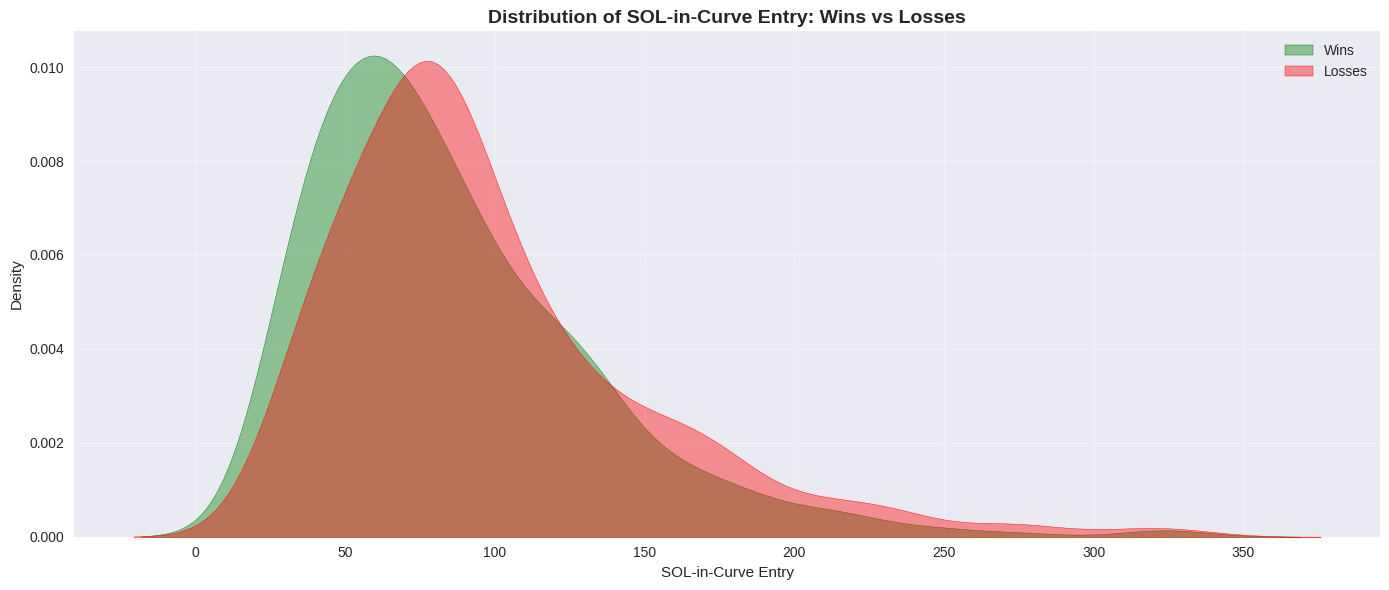

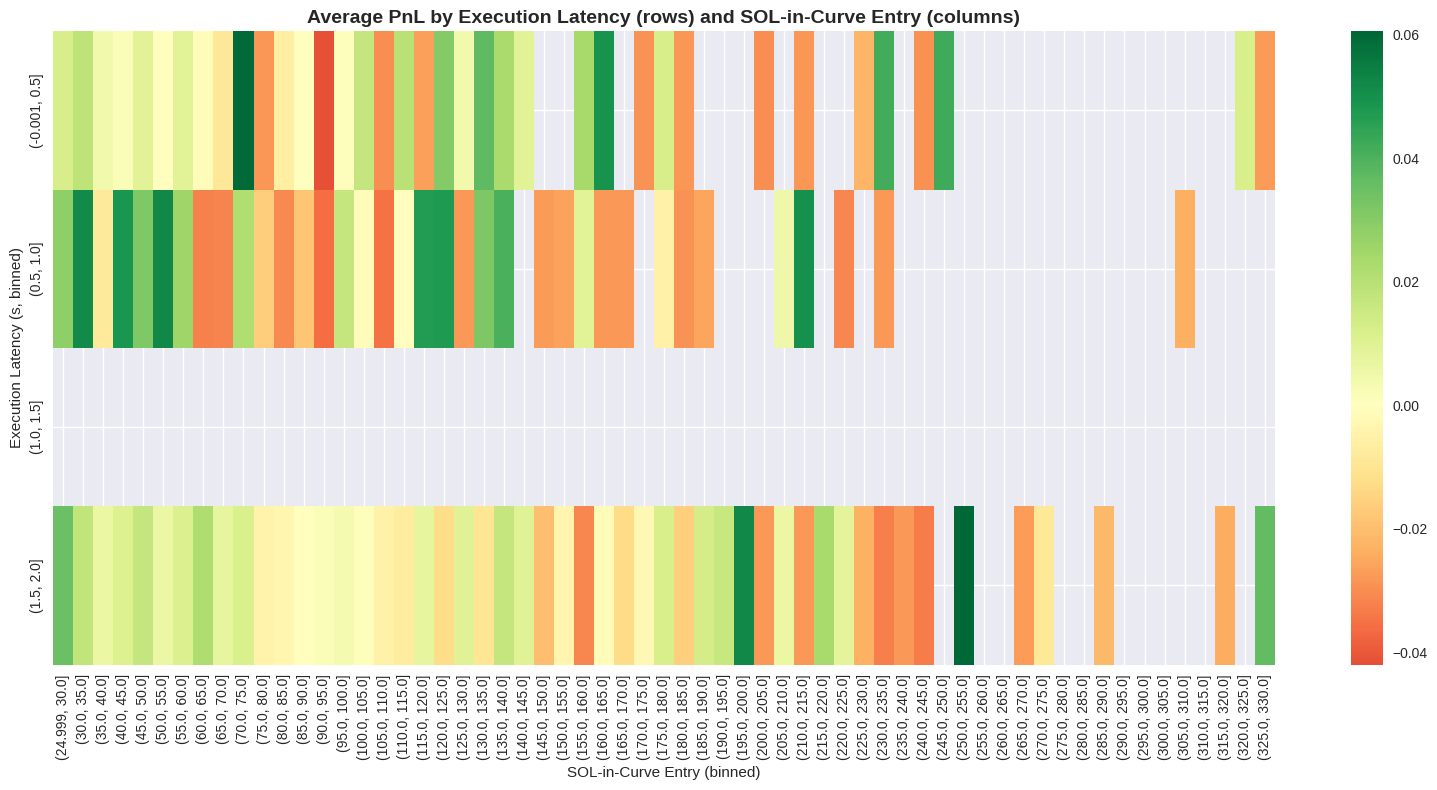


Top 10 (Latency Bin, SOL Entry Bin) by Average PnL:


,latency_bin,sol_entry_bin,avg_pnl
117,"(1.5, 2.0]","(250.0, 255.0]",0.06050
9,"(-0.001, 0.5]","(70.0, 75.0]",0.05930
107,"(1.5, 2.0]","(195.0, 200.0]",0.05230
42,"(0.5, 1.0]","(50.0, 55.0]",0.05226
38,"(0.5, 1.0]","(30.0, 35.0]",0.05162
69,"(0.5, 1.0]","(210.0, 215.0]",0.04990
25,"(-0.001, 0.5]","(160.0, 165.0]",0.04920
40,"(0.5, 1.0]","(40.0, 45.0]",0.04810
56,"(0.5, 1.0]","(120.0, 125.0]",0.04760
55,"(0.5, 1.0]","(115.0, 120.0]",0.04675



Bottom 10 (Latency Bin, SOL Entry Bin) by Average PnL:


,latency_bin,sol_entry_bin,avg_pnl
13,"(-0.001, 0.5]","(90.0, 95.0]",-0.041950
50,"(0.5, 1.0]","(90.0, 95.0]",-0.035733
53,"(0.5, 1.0]","(105.0, 110.0]",-0.035000
116,"(1.5, 2.0]","(240.0, 245.0]",-0.033300
114,"(1.5, 2.0]","(230.0, 235.0]",-0.032550
44,"(0.5, 1.0]","(60.0, 65.0]",-0.031975
45,"(0.5, 1.0]","(65.0, 70.0]",-0.031733
70,"(0.5, 1.0]","(220.0, 225.0]",-0.031200
99,"(1.5, 2.0]","(155.0, 160.0]",-0.031167
48,"(0.5, 1.0]","(80.0, 85.0]",-0.031000


In [122]:
# 12. EXTRA INSIGHTS: DISTRIBUTIONS AND 2D HEATMAPS
required_cols = {'sol_in_curve_entry', 'execution_latency_seconds'}
missing = required_cols - set(df.columns)
if missing:
    print(f"Missing columns in equity CSV: {missing}. Please regenerate equity CSVs with the latest code.")
else:
    # A) KDE of SOL-in-Curve Entry for Wins vs Losses
    wins = df[df['trade_pnl'] > 0]
    losses = df[df['trade_pnl'] <= 0]

    plt.figure(figsize=(14, 6))
    sns.kdeplot(wins['sol_in_curve_entry'], fill=True, alpha=0.4, label='Wins', color='green')
    sns.kdeplot(losses['sol_in_curve_entry'], fill=True, alpha=0.4, label='Losses', color='red')
    plt.title('Distribution of SOL-in-Curve Entry: Wins vs Losses', fontsize=14, fontweight='bold')
    plt.xlabel('SOL-in-Curve Entry')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # B) 2D Heatmap: Avg PnL by SOL-in-Curve Entry Bin vs Execution Latency Bin
    # Build bins
    sol_min = float(np.floor(df['sol_in_curve_entry'].min()))
    sol_max = float(np.ceil(df['sol_in_curve_entry'].max()))
    sol_span = max(sol_max - sol_min, 1.0)
    sol_step = 5.0 if sol_span > 50 else (2.0 if sol_span > 20 else 1.0)
    sol_bins = np.arange(sol_min - (sol_min % sol_step), sol_max + sol_step, sol_step)

    lat_min = float(np.floor(df['execution_latency_seconds'].min()))
    lat_max = float(np.ceil(df['execution_latency_seconds'].max()))
    lat_step = 0.5
    lat_bins = np.arange(lat_min, lat_max + lat_step, lat_step)

    tmp = df.copy()
    tmp['sol_entry_bin'] = pd.cut(tmp['sol_in_curve_entry'], bins=sol_bins, include_lowest=True)
    tmp['latency_bin'] = pd.cut(tmp['execution_latency_seconds'], bins=lat_bins, include_lowest=True)

    pivot = tmp.groupby(['latency_bin', 'sol_entry_bin'])['trade_pnl'].mean().unstack()

    plt.figure(figsize=(16, 8))
    sns.heatmap(pivot, cmap='RdYlGn', center=0, annot=False)
    plt.title('Average PnL by Execution Latency (rows) and SOL-in-Curve Entry (columns)', fontsize=14, fontweight='bold')
    plt.xlabel('SOL-in-Curve Entry (binned)')
    plt.ylabel('Execution Latency (s, binned)')
    plt.tight_layout()
    plt.show()

    # Print bins with best/worst average PnL combinations for quick insight
    stacked = pivot.stack().reset_index()
    stacked.columns = ['latency_bin', 'sol_entry_bin', 'avg_pnl']
    best = stacked.sort_values('avg_pnl', ascending=False).head(10)
    worst = stacked.sort_values('avg_pnl', ascending=True).head(10)

    print('\nTop 10 (Latency Bin, SOL Entry Bin) by Average PnL:')
    display(best)

    print('\nBottom 10 (Latency Bin, SOL Entry Bin) by Average PnL:')
    display(worst)

